**TODO**: 
* Evaluation at different granularity 


In [2]:
# Re-import necessary libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image

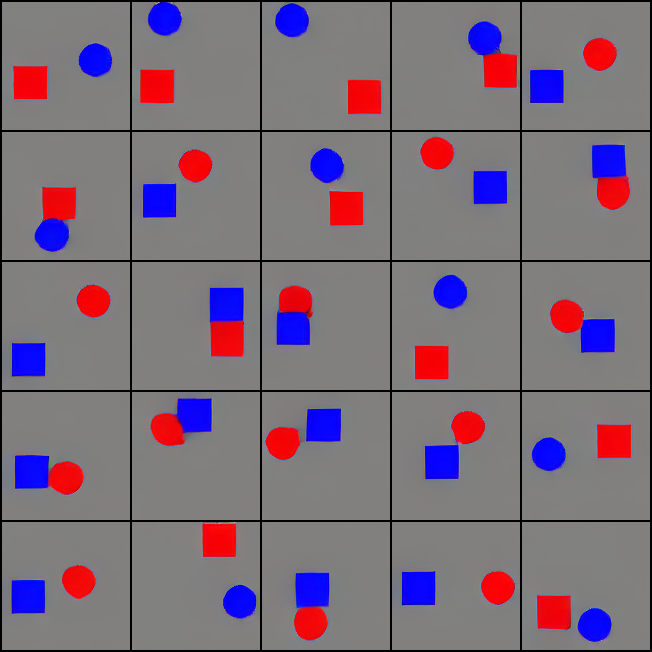

In [3]:
# Load the local image
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]

sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples"
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


def load_image(step_num, prompt_id, sample_root=sample_root):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=sample_root):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


prompt_id = 2
step_num = 10000
image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
image = Image.open(image_path)
image

### Detect object and classify

In [4]:
def find_classify_objects(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    classified_objects_df
    return classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)


12 triangle_is_to_the_left_of_square


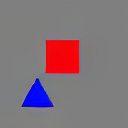

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (242, 6, 12)      (62, 57)  1067.5    1024.000000
1       1  Triangle   (6, 7, 244)    (36, 92.0)   428.0     443.405007


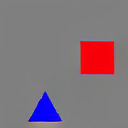

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       3    Square  (246, 3, 11)      (97, 58)  1038.0    1024.000000
1       1  Triangle  (12, 5, 244)   (45, 105.0)   464.5     443.405007


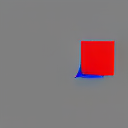

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (234, 7, 11)      (97, 58)  1028.5         1024.0


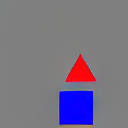

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       2  Triangle  (245, 11, 17)    (80, 67.0)   409.5     443.405007
1       1    Square    (8, 4, 251)     (76, 107)  1074.5    1024.000000


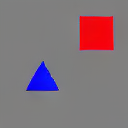

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (241, 7, 15)      (96, 33)  1071.5    1024.000000
1       1  Triangle  (16, 15, 242)    (42, 75.0)   460.0     443.405007


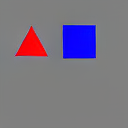

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (245, 6, 11)    (31, 40.0)   443.0     443.405007
1       1    Square  (11, 4, 249)      (79, 42)  1026.5    1024.000000


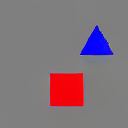

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (243, 5, 12)      (67, 90)  1056.5    1024.000000
1       1  Triangle  (11, 7, 245)    (96, 40.0)   477.5     443.405007


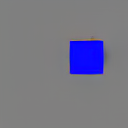

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 7, 251)      (86, 57)  1055.5         1024.0


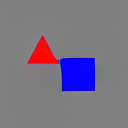

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (244, 10, 15)    (43, 49.0)   419.0     443.405007
1       3    Square   (10, 3, 248)      (77, 74)  1058.0    1024.000000


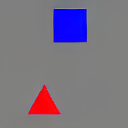

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (244, 10, 17)    (44, 98.0)   462.5     443.405007
1       1    Square    (9, 4, 249)      (70, 25)  1040.0    1024.000000


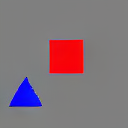

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (244, 8, 14)      (66, 56)  1095.5    1024.000000
1       1  Triangle  (16, 15, 243)    (25, 90.0)   483.0     443.405007


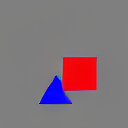

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square   (241, 6, 13)      (79, 74)  1069.0    1024.000000
1       1  Triangle  (13, 11, 242)    (55, 86.0)   441.5     443.405007


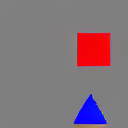

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       2    Square    (245, 3, 9)      (94, 49)  1010.5    1024.000000
1       1  Triangle  (15, 12, 246)   (90, 108.0)   508.5     443.405007


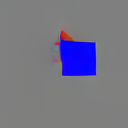

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 4, 248)      (77, 57)  1119.0         1024.0


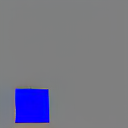

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (8, 5, 249)     (32, 105)  1067.5         1024.0


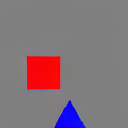

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (246, 8, 11)      (43, 73)  1048.5    1024.000000
1       1  Triangle  (16, 8, 245)   (69, 115.0)   405.5     443.405007


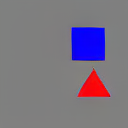

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (242, 10, 16)    (94, 83.0)   439.5     443.405007
1       1    Square   (12, 4, 247)      (88, 43)  1031.5    1024.000000


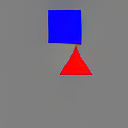

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (246, 7, 11)    (76, 62.0)   401.0     443.405007
1       1    Square  (11, 4, 248)      (65, 27)  1053.5    1024.000000


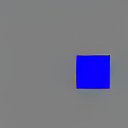

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 4, 248)      (93, 72)  1051.0         1024.0


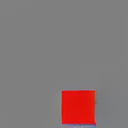

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (224, 20, 14)     (79, 107)  1046.0         1024.0


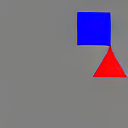

   Object     Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (247, 6, 9)   (110, 60.0)   451.0     443.405007
1       3    Square  (8, 3, 250)      (94, 28)  1045.0    1024.000000


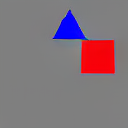

   Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1    Square  (244, 7, 14)      (98, 57)  1047.5    1024.000000
1       2  Triangle   (8, 7, 247)    (69, 24.0)   470.5     443.405007


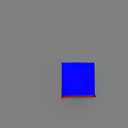

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (11, 7, 248)      (78, 78)  1012.0         1024.0


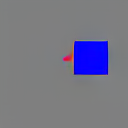

   Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (7, 3, 249)      (91, 58)  1068.5         1024.0


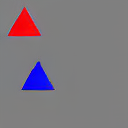

   Object     Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (243, 8, 14)    (25, 20.0)  458.5     443.405007
1       1  Triangle  (12, 9, 241)    (38, 75.0)  445.5     443.405007


In [5]:
# image = load_image(step_num, prompt_id)
# display(image)
step_num = 25000
prompt_id = 12
subimages = load_image_grid(step_num, prompt_id)
print(prompt_id, prompt_names[prompt_id])
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)


In [8]:
# def eval_from_df(df, target_object_info):
    # check if the target object is in the df
    


True

In [9]:
prompt_names

['blue_circle_is_above_and_to_the_right_of_blue_square',
 'blue_circle_is_above_blue_square',
 'blue_square_is_to_the_right_of_red_circle',
 'blue_triangle_is_above_red_triangle',
 'blue_triangle_is_to_the_upper_left_of_red_square',
 'circle_is_below_red_square',
 'red_circle_is_above_square',
 'red_circle_is_to_the_left_of_blue_square',
 'red_is_above_blue',
 'red_is_to_the_left_of_red',
 'triangle_is_above_and_to_the_right_of_square',
 'triangle_is_above_red_circle',
 'triangle_is_to_the_left_of_square',
 'triangle_is_to_the_left_of_triangle',
 'triangle_is_to_the_upper_left_of_square']

In [52]:
import pandas as pd

def evaluate_triangle_positions(df, MARGIN=25):
    """ blue_triangle_is_above_red_triangle
    Evaluates if a blue-dominant triangle is above a red-dominant triangle in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.

    Returns:
    bool: True if a blue-dominant triangle is above a red-dominant triangle, False otherwise.
    """
    # Validate input
    if df.empty:
        return False, "no object"
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        # return False, "no object"
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")
    # Extract triangles
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255-MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255-MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)
    # Identify red-dominant and blue-dominant triangles
    red_triangle = df.query("is_red == True and Shape == 'Triangle'")
    blue_triangle = df.query("is_blue == True and Shape == 'Triangle'")
    if red_triangle.empty:
        return False, "missing red triangle"
    if blue_triangle.empty:
        return False, "missing blue triangle"
    # Compare the y-coordinates (assuming y increases downwards)
    red_y = red_triangle['Center (x, y)'].iloc[0][1]
    red_x = red_triangle['Center (x, y)'].iloc[0][0]
    blue_y = blue_triangle['Center (x, y)'].iloc[0][1]
    blue_x = blue_triangle['Center (x, y)'].iloc[0][0]
    above = blue_y < red_y # and abs(blue_x - red_x) < 10
    if above:
        return True, "correct"
    else:
        return False, "spatial relation incorrect" # and abs(blue_x - red_x) < 10

In [92]:
import pandas as pd

def identity_spatial_relation(x1, y1, x2, y2):
    dx = x1 - x2  # Positive means shape1 is to the right
    dy = y1 - y2  # Positive means shape1 is lower
    # Define thresholds for "directly" above/below/left/right
    threshold = 5  # pixels
    if abs(dx) <= threshold:  # Roughly aligned vertically
        if dy < 0:
            observed_relation = 'above'
        else:
            observed_relation = 'below'
    elif abs(dy) <= threshold:  # Roughly aligned horizontally
        if dx < 0:
            observed_relation = 'left'
        else:
            observed_relation = 'right'
    else:  # Diagonal relationship
        if dx < 0 and dy < 0:
            observed_relation = 'upper_left'
        elif dx < 0 and dy > 0:
            observed_relation = 'lower_left'
        elif dx > 0 and dy < 0:
            observed_relation = 'upper_right'
        else:  # dx > 0 and dy > 0
            observed_relation = 'lower_right'
    return observed_relation


def evaluate_parametric_relation(df, scene_info, MARGIN=25):
    """ blue_triangle_is_above_red_triangle
    Evaluates if a blue-dominant triangle is above a red-dominant triangle in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing object detection details. It must include 
                       columns 'Shape', 'Color (RGB)', 'Center (x, y)', and 'Area'.

    Returns:
    bool: True if a blue-dominant triangle is above a red-dominant triangle, False otherwise.
    """
    # Validate input
    if df.empty:
        return False, "no object"
    if not all(col in df.columns for col in ['Shape', 'Color (RGB)', 'Center (x, y)']):
        # return False, "no object"
        raise ValueError("DataFrame must contain 'Shape', 'Color (RGB)', and 'Center (x, y)' columns.")
    shape1 = scene_info["shape1"] 
    shape2 = scene_info["shape2"]
    color1 = scene_info["color1"]
    color2 = scene_info["color2"]
    spatial_relationship = scene_info["spatial_relationship"]
    # Extract triangles
    df["is_red"] = df['Color (RGB)'].apply(lambda rgb: rgb[0] > 255-MARGIN and rgb[1] < MARGIN and rgb[2] < MARGIN)
    df["is_blue"] = df['Color (RGB)'].apply(lambda rgb: rgb[2] > 255-MARGIN and rgb[0] < MARGIN and rgb[1] < MARGIN)
    # Identify red-dominant and blue-dominant triangles
    mask1 = np.ones(len(df), dtype=bool)
    if shape1 is not None:
        mask1 = mask1 & (df['Shape'] == shape1)
    if color1 is not None:
        if color1 == "red":
            mask1 = mask1 & (df['is_red'] == True)
        elif color1 == "blue":
            mask1 = mask1 & (df['is_blue'] == True)
    obj1_df = df[mask1]
    if obj1_df.empty:
        return False, "missing object 1"
    
    mask2 = np.ones(len(df), dtype=bool)
    if shape2 is not None:
        mask2 = mask2 & (df['Shape'] == shape2)
    if color2 is not None:
        if color2 == "red":
            mask2 = mask2 & (df['is_red'] == True)
        elif color2 == "blue":
            mask2 = mask2 & (df['is_blue'] == True)
    obj2_df = df[mask2]
    if obj2_df.empty:
        return False, "missing object 2"

    # Compare the y-coordinates (assuming y increases downwards)
    if len(obj1_df) == 1 and len(obj2_df) == 1:
        x1, y1 = obj1_df['Center (x, y)'].iloc[0]
        x2, y2 = obj2_df['Center (x, y)'].iloc[0]
        observed_relation = identity_spatial_relation(x1, y1, x2, y2)
        rel_correct = spatial_relationship == observed_relation
    elif len(obj1_df) == len(obj2_df) == 2 and obj1_df.equals(obj2_df):
        # two objects are the same and the two objects can be in any order
        x1, y1 = obj1_df['Center (x, y)'].iloc[0]
        x2, y2 = obj1_df['Center (x, y)'].iloc[1]
        observed_relation1 = identity_spatial_relation(x1, y1, x2, y2)
        observed_relation2 = identity_spatial_relation(x2, y2, x1, y1)
        rel_correct = spatial_relationship in [observed_relation1, observed_relation2]
    else:
        return False, "number of objects incorrect"
    if rel_correct:
        return True, "correct"
    else:
        return False, "spatial relation incorrect" # and abs(blue_x - red_x) < 10


scene_info_collection = {'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_circle_is_above_and_to_the_right_of_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "upper_right"},
                        'blue_circle_is_above_blue_square':  {"color1": "blue", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "above"},
                        'blue_square_is_to_the_right_of_red_circle':  {"color1": "blue", "shape1": "Square", "color2": "red", "shape2": "Circle", "spatial_relationship": "right"},
                        'blue_triangle_is_above_red_triangle':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Triangle", "spatial_relationship": "above"},
                        'blue_triangle_is_to_the_upper_left_of_red_square':  {"color1": "blue", "shape1": "Triangle", "color2": "red", "shape2": "Square", "spatial_relationship": "upper_left"},
                        'circle_is_below_red_square':  {"color1": None, "shape1": "Circle", "color2": "red", "shape2": "Square", "spatial_relationship": "below"},
                        'red_circle_is_above_square':  {"color1": "red", "shape1": "Circle", "color2": None, "shape2": "Square", "spatial_relationship": "above"},
                        'red_circle_is_to_the_left_of_blue_square':  {"color1": "red", "shape1": "Circle", "color2": "blue", "shape2": "Square", "spatial_relationship": "left"},
                        'red_is_above_blue':  {"color1": "red", "shape1": None, "color2": "blue", "shape2": None, "spatial_relationship": "above"},  # TODO: check 
                        'red_is_to_the_left_of_red':  {"color1": "red", "shape1": None, "color2": "red", "shape2": None, "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_above_and_to_the_right_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_right"},
                        'triangle_is_above_red_circle':  {"color1": None, "shape1": "Triangle", "color2": "red", "shape2": "Circle", "spatial_relationship": "above"},
                        'triangle_is_to_the_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "left"},
                        'triangle_is_to_the_left_of_triangle':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Triangle", "spatial_relationship": "left"},  # TODO: check 
                        'triangle_is_to_the_upper_left_of_square':  {"color1": None, "shape1": "Triangle", "color2": None, "shape2": "Square", "spatial_relationship": "upper_left"},
                        }


def eval_func_factory(prompt_name):
    return lambda df: evaluate_parametric_relation(df, scene_info_collection[prompt_name])


In [85]:
prompt_names[prompt_id]
eval_func_collection = {'blue_triangle_is_above_red_triangle': None,
                        'blue_circle_is_above_and_to_the_right_of_blue_square': None,
                        'blue_circle_is_above_blue_square': None,
                        'blue_square_is_to_the_right_of_red_circle': None,
                        'blue_triangle_is_above_red_triangle': evaluate_triangle_positions,
                        'blue_triangle_is_to_the_upper_left_of_red_square': None,
                        'circle_is_below_red_square': None,
                        'red_circle_is_above_square': None,
                        'red_circle_is_to_the_left_of_blue_square': None,
                        'red_is_above_blue': None,
                        'red_is_to_the_left_of_red': None,   
                        'triangle_is_above_and_to_the_right_of_square': None,
                        'triangle_is_above_red_circle': None,
                        'triangle_is_to_the_left_of_square': None,
                        'triangle_is_to_the_left_of_triangle': None,
                        'triangle_is_to_the_upper_left_of_square': None
                        }



In [55]:
prompt_names[prompt_id]

'blue_triangle_is_above_red_triangle'

3 blue_triangle_is_above_red_triangle


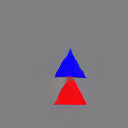

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (235, 17, 24)    (70, 92.0)  478.5     443.405007
1       1  Triangle  (21, 11, 240)    (71, 62.0)  399.0     443.405007
(True, 'correct')


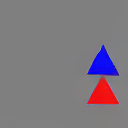

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (236, 21, 23)     (103, 91)  432.0    1024.000000
1       2   Triangle  (16, 12, 238)   (102, 58.0)  429.0     443.405007
(False, 'missing object 2')


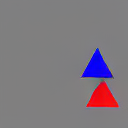

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (239, 12, 20)   (103, 95.0)  433.0     443.405007
1       1  Triangle   (14, 4, 241)    (97, 62.0)  420.5     443.405007
(False, 'spatial relation incorrect')


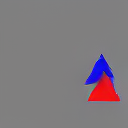

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (234, 17, 25)   (104, 89.0)  421.0     443.405007
1       2    Square  (28, 21, 224)      (99, 70)  308.5    1024.000000
(False, 'missing object 1')


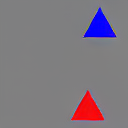

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (241, 13, 18)   (87, 104.0)  482.5     443.405007
1       3  Triangle   (10, 5, 248)    (99, 21.0)  449.5     443.405007
(False, 'spatial relation incorrect')


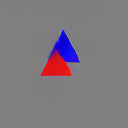

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (222, 23, 26)      (56, 65)  400.0    1024.000000
1       2     Circle  (25, 12, 226)      (66, 46)  361.0     804.247719
(False, 'missing object 1')


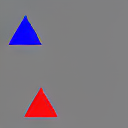

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (243, 13, 16)   (41, 101.0)  463.0     443.405007
1       5  Triangle   (12, 6, 245)    (24, 29.0)  456.0     443.405007
(False, 'spatial relation incorrect')


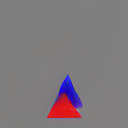

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1   Triangle  (217, 24, 30)   (64, 110.0)  387.0     443.405007
1       4  Rectangle  (34, 24, 207)      (68, 89)  143.0    1024.000000
(False, 'missing object 1')


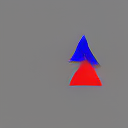

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (234, 19, 25)    (86, 75.0)  443.5     443.405007
1       1    Square  (24, 12, 224)      (83, 50)  307.5    1024.000000
(False, 'missing object 1')


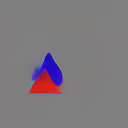

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (209, 33, 30)      (45, 84)  302.5    1024.000000
1       7     Circle  (42, 18, 198)      (47, 69)  271.5     804.247719
(False, 'missing object 1')


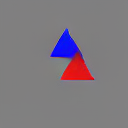

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (222, 22, 24)    (77, 71.0)  424.5     443.405007
1       1    Square  (19, 19, 240)      (64, 43)  418.5    1024.000000
(False, 'missing object 1')


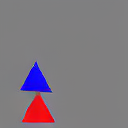

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (237, 15, 23)   (38, 108.0)  484.0     443.405007
1       4  Triangle  (22, 10, 239)    (35, 75.0)  423.5     443.405007
(True, 'correct')


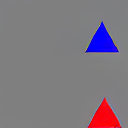

   Object     Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (246, 7, 19)  (104, 111.0)  489.0     443.405007
1       4  Triangle   (9, 2, 247)   (102, 35.0)  451.0     443.405007
(True, 'correct')


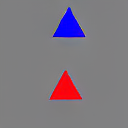

   Object     Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (243, 9, 19)    (66, 84.0)  462.5     443.405007
1       3  Triangle  (10, 4, 246)    (68, 20.0)  458.5     443.405007
(True, 'correct')


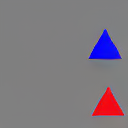

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (237, 15, 25)  (108, 100.0)  435.0     443.405007
1       3  Triangle  (15, 12, 241)   (104, 42.0)  480.5     443.405007
(False, 'missing object 2')


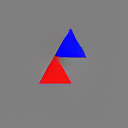

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (236, 21, 23)    (55, 70.0)  447.5     443.405007
1       2  Triangle  (13, 11, 243)    (70, 42.0)  429.0     443.405007
(False, 'spatial relation incorrect')


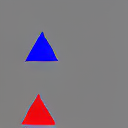

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (236, 11, 19)   (38, 108.0)  491.5     443.405007
1       4  Triangle   (10, 7, 244)    (42, 45.0)  451.0     443.405007
(True, 'correct')


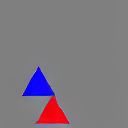

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle   (239, 8, 18)   (53, 110.0)  421.0     443.405007
1       5  Triangle  (17, 10, 244)    (38, 80.0)  462.5     443.405007
(False, 'spatial relation incorrect')


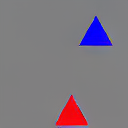

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (240, 11, 20)   (72, 108.0)  483.0     443.405007
1       9  Triangle   (11, 4, 246)    (96, 29.0)  443.5     443.405007
(False, 'spatial relation incorrect')


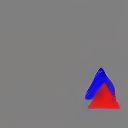

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (218, 28, 30)   (104, 99.0)  347.0     443.405007
1       2    Square  (34, 21, 217)      (99, 83)  296.0    1024.000000
(False, 'missing object 1')


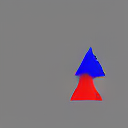

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (234, 21, 22)      (86, 89)  428.5    1024.000000
1       1   Triangle  (20, 14, 233)    (89, 60.0)  399.5     443.405007
(False, 'missing object 2')


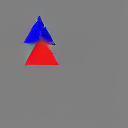

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (230, 25, 30)      (41, 53)  446.5         1024.0
1       1     Square  (22, 13, 219)      (38, 30)  297.5         1024.0
(False, 'missing object 1')


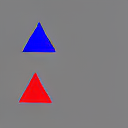

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (240, 11, 20)    (35, 86.0)  467.5     443.405007
1       3  Triangle    (9, 5, 246)    (39, 35.0)  451.5     443.405007
(True, 'correct')


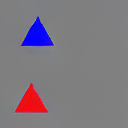

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (236, 17, 21)    (31, 97.0)  446.5     443.405007
1       2  Triangle   (13, 9, 243)    (37, 30.0)  460.0     443.405007
(False, 'spatial relation incorrect')


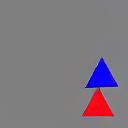

   Object     Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (243, 10, 20)   (98, 104.0)  424.0     443.405007
1       3  Triangle   (12, 4, 243)   (102, 71.0)  444.0     443.405007
(True, 'correct')


In [57]:
step_num = 50000
prompt_id = 3
subimages = load_image_grid(step_num, prompt_id)
print(prompt_id, prompt_names[prompt_id])
scene_info = {"shape1": "Triangle", "shape2": "Triangle", 
              "color1": "blue", "color2": "red", 
              "spatial_relationship": "above"}

eval_func = lambda df: evaluate_parametric_relation(df, scene_info)
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)
    print(eval_func(classified_objects_df))

In [93]:
from tqdm.auto import trange, tqdm
# image = load_image(step_num, prompt_id)
# display(image)
prompt_id = 3
eval_score = []
object_df_col = []
for prompt_id in range(len(prompt_names)):
    print(prompt_id, prompt_names[prompt_id])
    eval_func = eval_func_factory(prompt_names[prompt_id])
    for step_num in trange(2500, 160000, 2500):
        subimages = load_image_grid(step_num, prompt_id)
        for si, subimage in enumerate(subimages):
            classified_objects_df = find_classify_objects(subimage)
            object_df_col.append(classified_objects_df)
            correctness, reason = eval_func(classified_objects_df)
            eval_score.append({"step_num": step_num, "sample_id": si, "prompt_id": prompt_id, 
                "correctness": correctness, "reason": reason})
        
eval_score_df = pd.DataFrame(eval_score)


0 blue_circle_is_above_and_to_the_right_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

1 blue_circle_is_above_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

2 blue_square_is_to_the_right_of_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

3 blue_triangle_is_above_red_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

4 blue_triangle_is_to_the_upper_left_of_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

5 circle_is_below_red_square


  0%|          | 0/63 [00:00<?, ?it/s]

6 red_circle_is_above_square


  0%|          | 0/63 [00:00<?, ?it/s]

7 red_circle_is_to_the_left_of_blue_square


  0%|          | 0/63 [00:00<?, ?it/s]

8 red_is_above_blue


  0%|          | 0/63 [00:00<?, ?it/s]

9 red_is_to_the_left_of_red


  0%|          | 0/63 [00:00<?, ?it/s]

10 triangle_is_above_and_to_the_right_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

11 triangle_is_above_red_circle


  0%|          | 0/63 [00:00<?, ?it/s]

12 triangle_is_to_the_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

13 triangle_is_to_the_left_of_triangle


  0%|          | 0/63 [00:00<?, ?it/s]

14 triangle_is_to_the_upper_left_of_square


  0%|          | 0/63 [00:00<?, ?it/s]

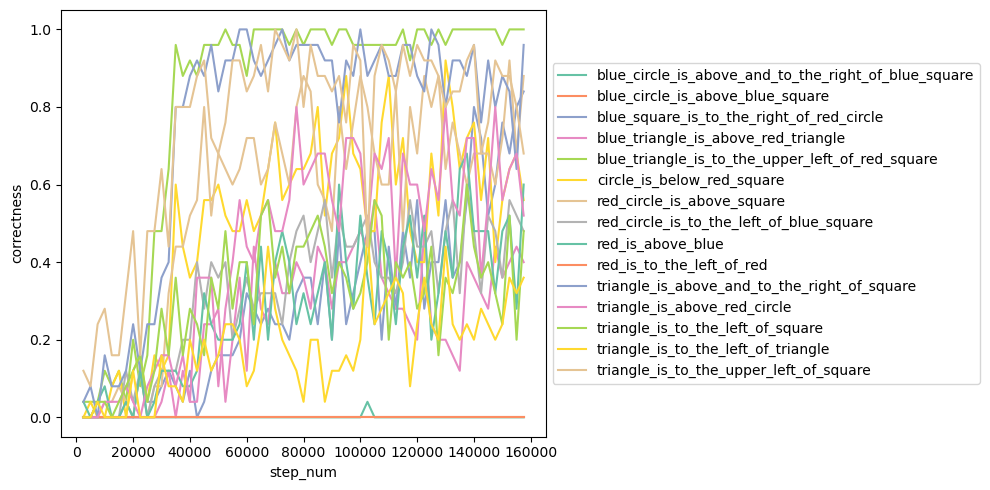

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
# label the hue with prompt names
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"correctness": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])
plt.figure(figsize=(10, 5))
sns.lineplot(data=score_tab, x="step_num", y="correctness", hue="prompt_name", palette="Set2", )
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# move the legend to the right
# plt.legend(title="Prompt", labels=prompt_names)

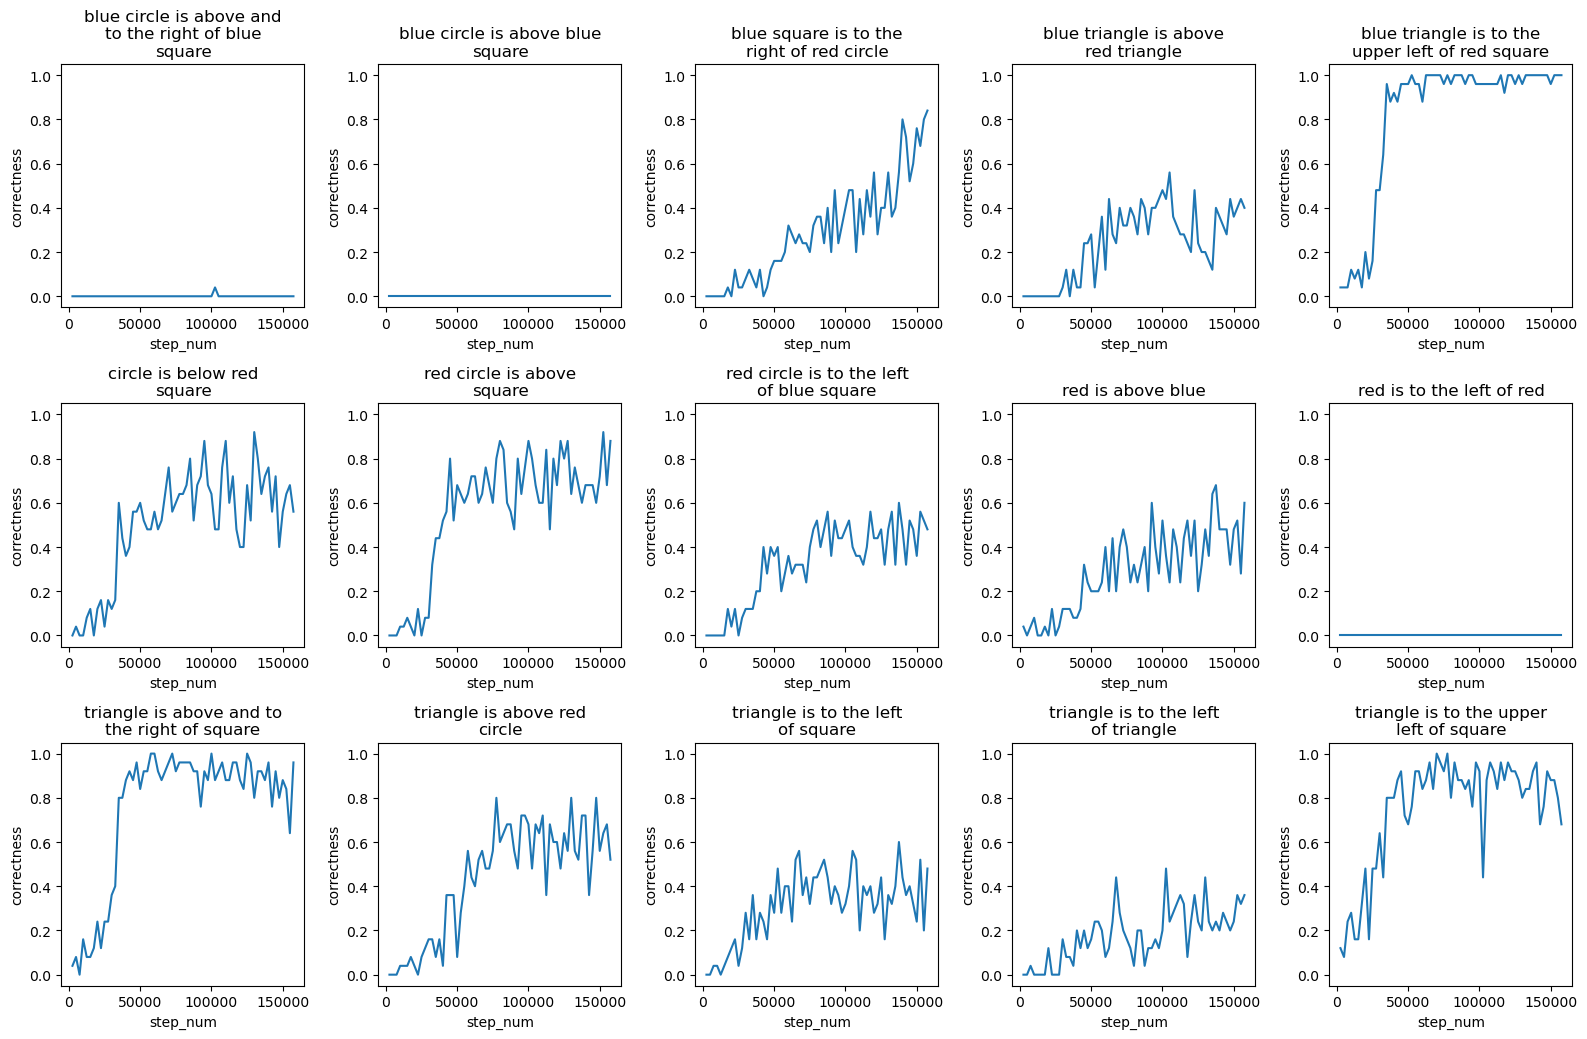

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
# label the hue with prompt names
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"correctness": "mean"}).reset_index()
score_tab["prompt_name"] = score_tab["prompt_id"].apply(lambda x: prompt_names[x])
# Create a multi-panel plot
n_prompts = len(prompt_names)
n_cols = 5
n_rows = (n_prompts + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5*n_rows))
axes = axes.flatten()
# Plot each prompt in its own panel
for i, prompt in enumerate(prompt_names):
    prompt_data = score_tab[score_tab["prompt_name"] == prompt]
    sns.lineplot(data=prompt_data, x="step_num", y="correctness", ax=axes[i])
    # wrap the title if too long 
    prompt = prompt.replace("_", " ")
    if len(prompt) > 10:
        prompt = "\n".join(textwrap.wrap(prompt, width=25))
    axes[i].set_title(prompt)
    axes[i].set_ylim(-0.05, 1.05)
# Remove empty subplots if any
for i in range(len(prompt_names), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()

<Axes: xlabel='step_num', ylabel='correctness'>

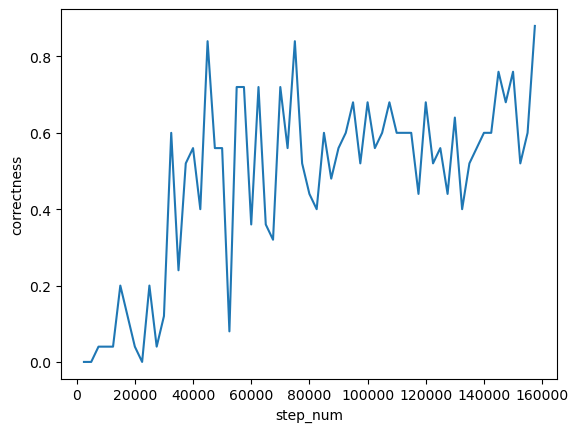

In [40]:
score_tab = eval_score_df.groupby(["step_num", "prompt_id"]).agg({"correctness": "mean"}).reset_index()
sns.lineplot(data=score_tab, x="step_num", y="correctness")

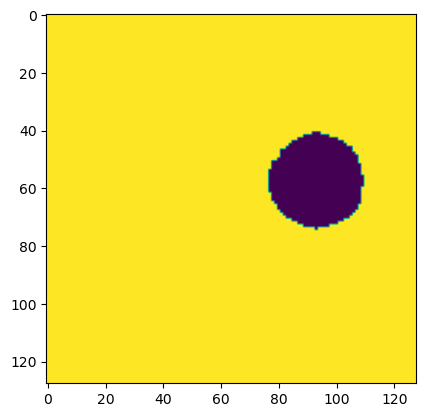

In [25]:
import matplotlib.pyplot as plt
plt.imshow(binary_mask)

,Object,Shape,Color (RGB),"Center (x, y)"
0,1,Square,"(129, 112, 126)","(64, 64)"


In [ ]:

subimages = load_image_grid(step_num, prompt_id)
# Reload the image
# image_path = "/mnt/data/35770291-C7B3-46DC-B609-516FE6349F33.png

image = np.array(subimages[0]) #cv2.imread(image_path)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
classified_objects = []
for channel in range(3):
    gray_image = image[:,:,channel]
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the shapes
    contours, _ = cv2.findContours(binary_mask, 
                                cv2.RETR_EXTERNAL, 
                                cv2.CHAIN_APPROX_SIMPLE)

    # Initialize results
    for i, contour in enumerate(contours):
        # Calculate properties of the contour
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        # Shape classification based on the number of vertices
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Square" if abs(w - h) < 5 else "Rectangle"
        elif len(approx) > 4:
            shape = "Circle"
        else:
            shape = "Unknown"
        # Calculate the color of the shape by extracting the region
        mask = np.zeros_like(gray_image)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(image, mask=mask)
        # Add to results
        classified_objects.append({
            "Object": i + 1,
            "Shape": shape,
            "Color (RGB)": tuple(map(int, mean_color[:3])),
            "Center (x, y)": (x + w // 2, y + h // 2),
            "Area": area
            
        })

# Convert to DataFrame for better visualization
classified_objects_df = pd.DataFrame(classified_objects)
classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)

,Object,Shape,Color (RGB),"Center (x, y)",Area
0,1,Square,"(246, 1, 8)","(28, 80)",1010.0
1,1,Circle,"(5, 5, 252)","(93, 58)",790.5
